#Project Overview
Computer vision can be used to automate supervision and trigger appropriate actions if an event is predicted from an image of interest.
For example, food items can be easily identified by a camera based on:

- The type of food

- Color

- Ingredients, etc.

## 📊 Data Description
The Food101 dataset contains 16,256 images across 17 food classes.

Each class can be roughly split into 70% training and 30% testing.

Classes are typically food names (e.g., apple_pie, chicken_curry).

The dataset has already been attached with this project. Please use the same version provided.

## 📎 Original Dataset Link for Reference Only:
Food101 Dataset on Kaggle

## 📖 Reference
The dataset was originally introduced in the paper:
"Food-101 – Mining Discriminative Components with Random Forests"
Authors: Lukas Bossard, Matthieu Guillaumin, Luc Van Gool



# Import all libirary

In [ ]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs
from collections import defaultdict
import random
import shutil
import os



# Tensorflow modules
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
                                                                                                # Importing the sequential module to define a sequential model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [ ]:
# Uncomment and run the following code in case Google Colab is being used
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Python Course_shared/computer Vision/Food_101.zip'


Streaming output truncated to the last 5000 lines.
  inflating: Food_101/nachos/2305287.jpg  
  inflating: __MACOSX/Food_101/nachos/._2305287.jpg  
  inflating: Food_101/nachos/2644747.jpg  
  inflating: __MACOSX/Food_101/nachos/._2644747.jpg  
  inflating: Food_101/nachos/1425651.jpg  
  inflating: __MACOSX/Food_101/nachos/._1425651.jpg  
  inflating: Food_101/nachos/835919.jpg  
  inflating: __MACOSX/Food_101/nachos/._835919.jpg  
  inflating: Food_101/nachos/908454.jpg  
  inflating: __MACOSX/Food_101/nachos/._908454.jpg  
  inflating: Food_101/nachos/2553526.jpg  
  inflating: __MACOSX/Food_101/nachos/._2553526.jpg  
  inflating: Food_101/nachos/1323906.jpg  
  inflating: __MACOSX/Food_101/nachos/._1323906.jpg  
  inflating: Food_101/nachos/3228958.jpg  
  inflating: __MACOSX/Food_101/nachos/._3228958.jpg  
  inflating: Food_101/nachos/346658.jpg  
  inflating: __MACOSX/Food_101/nachos/._346658.jpg  
  inflating: Food_101/nachos/2702921.jpg  
  inflating: __MACOSX/Food_101/nachos/.

In [ ]:
# Image folder
food_101_image_folder = '/content/Food_101/'

MetaData Class

In [ ]:
# Metadat Class for storing it
class IdentityMetadata():
    def __init__(self, base, name, file, size):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file
        self.size=size

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)


#### Helper Functions

In [ ]:
def load_metadata(path):
    """
    Load metadata for all images in a directory
    """
    if not os.path.exists(path):
        raise ValueError(f"Path does not exist: {path}")

    metadata = []
    for index, folder in enumerate(os.listdir(path)):
        subdir_path = os.path.join(path, folder)
        if not os.path.isdir(subdir_path):
            continue  # Skip files like .DS_Store or any non-folder

        # Get all valid image files in the subdirectory
        image_files = [f for f in os.listdir(subdir_path)
                       if f.lower().endswith(('.jpg', '.jpeg'))]

        total_images = len(image_files)

        for file in image_files:
            metadata.append(IdentityMetadata(path, folder, file, total_images))

    return np.array(metadata)


In [ ]:
# Read & Load Image
def load_image(path):
  """
  Load image from path
  """
  img = cv2.imread(path)
  # Convert to RGB
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



---





## Exploratory Data Analysis


In [ ]:
# load image metadata from folder
metadata = load_metadata(food_101_image_folder)

In [ ]:
# Show shape of metadata
metadata.shape

(16256,)

In [ ]:
# Select 5 images per class (name)
seen = {}
filtered = []

for item in metadata:
    if seen.get(item.name,0) < 5:
        filtered.append(item)
        value=seen.get(item.name,0)
        seen[item.name]=value+1

print(f"Total no of classes {len(seen.keys())}")
print(f"Classes Present {list(seen.keys())}")



Total no of classes 17
Classes Present ['pizza', 'tacos', 'ice_cream', 'nachos', 'french_fries', 'spring_rolls', 'chocolate_cake', 'apple_pie', 'ravioli', 'strawberry_shortcake', 'donuts', 'falafel', 'hot_dog', 'onion_rings', 'waffles', 'pancakes', 'samosa']


### Observations:
 - We have around 17 classes of food .
  - pizza  
  - tacos  
  - ice_cream  
  - nachos  
  - french_fries  
  - spring_rolls  
  - chocolate_cake  
  - apple_pie  
  - ravioli  
  - strawberry_shortcake  
  - donuts  
  - falafel  
  - hot_dog  
  - onion_rings  
  - waffles  
  - pancakes  
  - samosa  
  



In [ ]:
class_map={}
for i in range(0,len(metadata)):
    if seen.get(metadata[i].name,0) !=0:
        class_map[metadata[i].name]= metadata[i].size
df=pd.DataFrame(class_map,index=[0]).T
df.columns = ['class_size']
df.index.name = 'class_name'

In [ ]:
df

class_size
class_name                      
pizza                       1000
tacos                       1000
ice_cream                   1000
nachos                      1000
french_fries                1000
spring_rolls                1000
chocolate_cake              1000
apple_pie                    256
ravioli                     1000
strawberry_shortcake        1000
donuts                      1000
falafel                     1000
hot_dog                     1000
onion_rings                 1000
waffles                     1000
pancakes                    1000
samosa                      1000

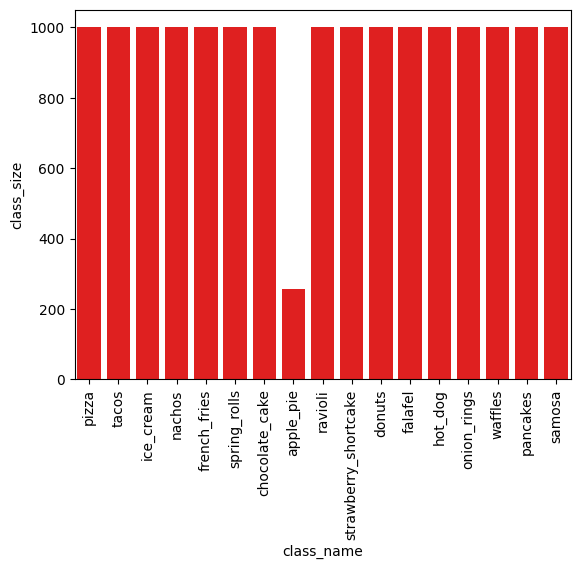

In [ ]:
# show in barplot
sns.barplot(x=df.index, y=df['class_size'],color='r')
plt.xticks(rotation=90)
plt.show()

### Observation:
-  All of the classes has 1000 images apart from applie_pie which has 256 images



### Show 5 Images from Each class

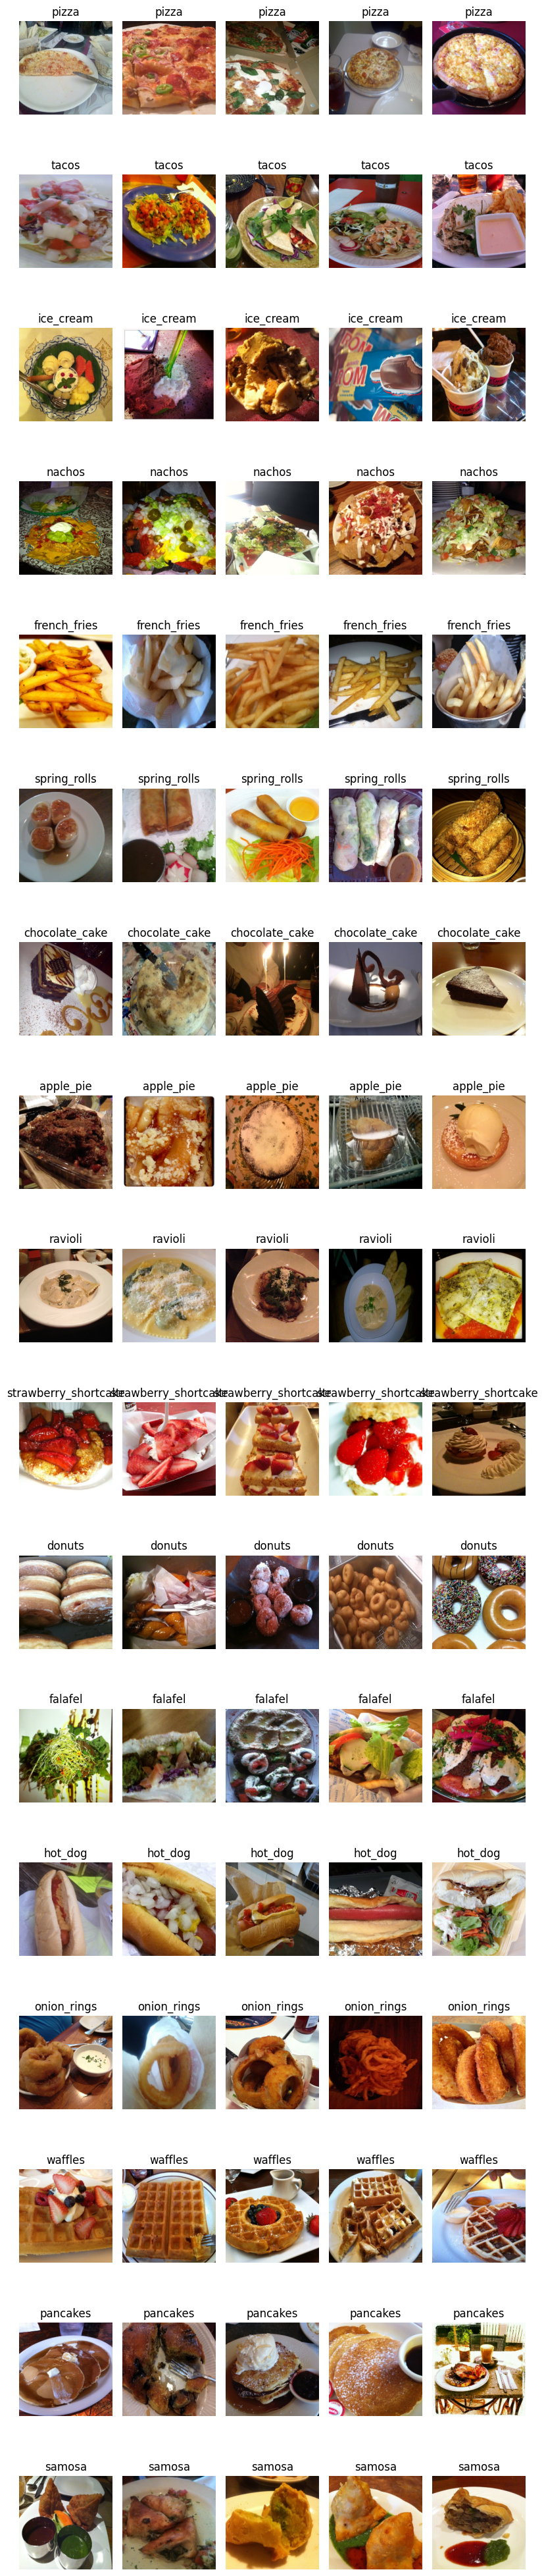

In [ ]:
# Limit to 34 images for 17x5 grid

# Set up 17 rows × 5 columns
fig, axes = plt.subplots(17, 5, figsize=(8, 40))
axes = axes.flatten()

for i in range(len(filtered)):
    img = cv2.imread(filtered[i].image_path())
    if img is None:
        continue
    img_resized = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    axes[i].imshow(img_rgb)
    axes[i].set_title(filtered[i].name)
    axes[i].axis('off')

# Turn off any remaining axes
for j in range(len(filtered), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Preparing Data Set (Annotated)
 We have annotated the datset and created a seperate annotation_csv file which contains imagename,classname and xcenter,ycenter,width,height (yolo format) all normalised 0to1.We will be using the same dataset for the model data preprartion and training

In [ ]:
!unzip '/content/drive/MyDrive/Python Course_shared/computer Vision/Food-101-Annotated-V2.zip'

Archive:  /content/drive/MyDrive/Python Course_shared/computer Vision/Food-101-Annotated-V2.zip
   creating: Food-101-Annotated/
  inflating: __MACOSX/._Food-101-Annotated  
   creating: Food-101-Annotated/ice_cream/
  inflating: __MACOSX/Food-101-Annotated/._ice_cream  
   creating: Food-101-Annotated/samosa/
  inflating: __MACOSX/Food-101-Annotated/._samosa  
  inflating: Food-101-Annotated/.DS_Store  
  inflating: __MACOSX/Food-101-Annotated/._.DS_Store  
   creating: Food-101-Annotated/onion_ring/
  inflating: __MACOSX/Food-101-Annotated/._onion_ring  
   creating: Food-101-Annotated/strawberry_shortcake/
  inflating: __MACOSX/Food-101-Annotated/._strawberry_shortcake  
   creating: Food-101-Annotated/waffle/
  inflating: __MACOSX/Food-101-Annotated/._waffle  
  inflating: Food-101-Annotated/annotation_refined.csv  
  inflating: __MACOSX/Food-101-Annotated/._annotation_refined.csv  
   creating: Food-101-Annotated/chocolate_cake/
  inflating: __MACOSX/Food-101-Annotated/._chocolate

In [ ]:
base_path='/content/Food-101-Annotated'

In [ ]:
# load image metadata from folder
metadata_annotated = load_metadata(base_path)
annotation_df=pd.read_csv(f"{base_path}/annotation_refined.csv")

In [ ]:
annotation_df.head(5)

image    class_name  x_center  y_center     width    height
0  1199754.jpg  french_fries  0.509375  0.522656  0.720313  0.771875
1  1232631.jpg        nachos  0.178125  0.717969  0.351562  0.439063
2  1232631.jpg        nachos  0.522656  0.511719  0.932813  0.954688
3  2616112.jpg        nachos  0.165625  0.526563  0.214844  0.465625
4  2616112.jpg        nachos  0.394531  0.482812  0.171875  0.379688

### Train Test Split With Image Generator

In [ ]:
# Take first image only as there might have duplicate entryfor same image as same image mutiple instances of same food item
classification_df = annotation_df.groupby('image').first().reset_index()
# create a new volumn file name by concating the classname this will help us in using df for image data generator
classification_df['image_name'] = classification_df.apply(lambda row: f"{row['class_name']}/{row['image']}", axis=1)
# train test split with dividing the class in same propertion
train_df, temp_df = train_test_split(
    classification_df,
    test_size=0.2,
    stratify=classification_df['class_name'],  # ensures class distribution is preserved
    random_state=42)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['class_name'],  # ensures class distribution is preserved
    random_state=42)



In [ ]:
print(f"Training Set ->{train_df.shape}",f"Validation Set ->{valid_df.shape}",f"Test Set ->{test_df.shape}")

Training Set ->(447, 7) Validation Set ->(56, 7) Test Set ->(56, 7)


In [ ]:
df_1=classification_df.groupby('class_name').agg({'image':'count'}).reset_index()
df_2=train_df.groupby('class_name').agg({'image':'count'}).reset_index()
# Rename columns for clarity
df_1 = df_1.rename(columns={'image': 'total_count'})
df_2 = df_2.rename(columns={'image': 'train_count'})

# Merge on 'class_name'
result_df = pd.merge(df_1, df_2, on='class_name', how='outer')
result_df

class_name  total_count  train_count
0        chocolate_cake           51           41
1          french_fries           78           62
2             ice_cream           54           43
3                nachos           48           38
4            onion_ring           50           40
5                 pizza           58           46
6                samosa           71           57
7  strawberry_shortcake           50           40
8                 tacos           52           42
9                waffle           47           38

- We can see we have 447 for training 56 for testing and 56 will be for valiadation
- We can see each class is equally distributed 80% of total image set for the class from the aboce dataframe

In [ ]:

# Define Image data generator for train and testvalidation
train_datagen =ImageDataGenerator(
                 horizontal_flip=True,
                 vertical_flip=True,
                 rotation_range=15,
                 width_shift_range=0.1,
                 height_shift_range=0.1,
                 zoom_range=0.2,
                 shear_range=0.1,
                 fill_mode='nearest',
                 rescale=1/255) #rescale to [0-1], add zoom range of 0.2x and horizontal flip
test_valid_datagen = ImageDataGenerator(rescale=1./255)


# Create training image gen
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory=base_path,  # base path
    x_col='image_name',
    y_col='class_name',
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=True
)

# Create test image gen
test_gen = test_valid_datagen.flow_from_dataframe(
    test_df,
    directory=base_path,
    x_col='image_name',
    y_col='class_name',
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=False
)
# Create valid image gen

valid_gen = test_valid_datagen.flow_from_dataframe(
    valid_df,
    directory=base_path,
    x_col='image_name',
    y_col='class_name',
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=False
)

Found 446 validated image filenames belonging to 10 classes.
Found 56 validated image filenames belonging to 10 classes.
Found 56 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
print(train_gen.class_indices)
print(valid_gen.class_indices)
print(test_gen.class_indices)

{'chocolate_cake': 0, 'french_fries': 1, 'ice_cream': 2, 'nachos': 3, 'onion_ring': 4, 'pizza': 5, 'samosa': 6, 'strawberry_shortcake': 7, 'tacos': 8, 'waffle': 9}
{'chocolate_cake': 0, 'french_fries': 1, 'ice_cream': 2, 'nachos': 3, 'onion_ring': 4, 'pizza': 5, 'samosa': 6, 'strawberry_shortcake': 7, 'tacos': 8, 'waffle': 9}
{'chocolate_cake': 0, 'french_fries': 1, 'ice_cream': 2, 'nachos': 3, 'onion_ring': 4, 'pizza': 5, 'samosa': 6, 'strawberry_shortcake': 7, 'tacos': 8, 'waffle': 9}


### Train Test Split Normal

In [ ]:
images = []
labels = []
for i in metadata_annotated:
  img = cv2.imread(i.image_path())
  if img is None:
    continue
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (128, 128))
  images.append(img_resized/255.0)
  labels.append(i.name)


In [ ]:
# Convert lists to arrays
X = np.array(images)
y = np.array(labels)

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # one-hot encoding

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Shapes
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Valid: {X_valid.shape}, {y_valid.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (452, 128, 128, 3), (452, 10)
Valid: (56, 128, 128, 3), (56, 10)
Test: (57, 128, 128, 3), (57, 10)


### Model Creation

### Helper Function

In [ ]:
def build_basic_cnn(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third Convolutional Block (Optional, but good for slightly more complexity)
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the 3D output to 1D for the Dense layers
    model.add(Flatten())

    # Dense (Fully Connected) Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5)) # Dropout for regularization to prevent overfitting
    model.add(Dense(num_classes, activation='softmax')) # Output layer for classification

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
def build_basic_cnn_2(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third Convolutional Block (Optional, but good for slightly more complexity)
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Fourth Convolutional Block (Optional, but good for slightly more complexity)
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the 3D output to 1D for the Dense layers
    model.add(Flatten())

    # Dense (Fully Connected) Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5)) # Dropout for regularization to prevent overfitting
    model.add(Dense(num_classes, activation='softmax')) # Output layer for classification

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:

def get_callbacks(filepath='cnn_model.weights.h5'):
    """
    Returns a tuple of callbacks: ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau.

    Parameters:
    -----------
    filepath : str
        Path to save the model weights.

    Returns:
    --------
    tuple :
        (ModelCheckpoint, EarlyStopping, ReduceLROnPlateau)
    """
    checkpointer = ModelCheckpoint(
        filepath=filepath,
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    )

    earlystopping = EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=20,
        mode='auto'
    )

    reduceLR = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        mode='auto'
    )

    return checkpointer, earlystopping, reduceLR


In [ ]:

def plot_model_accuracy(history,model):
    """
    Plots the accuracy and loss trends over epochs for a trained neural network.

    Parameters:
    - history: Keras History object containing training metrics.

    Displays:
    - Subplot 1: Training & Validation Accuracy vs. Epochs
    - Subplot 2: Training & Validation Loss vs. Epochs
    """

    h1 = history.history  # Extract training history

    # Get the final values for display in titles
    final_train_acc = h1['accuracy'][-1]
    final_val_acc = h1['val_accuracy'][-1]
    final_train_loss = h1['loss'][-1]
    final_val_loss = h1['val_loss'][-1]

    plt.figure(figsize=(15, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(y=h1['accuracy'], x=range(len(h1['accuracy'])), label="Training Accuracy", color="green")
    sns.lineplot(y=h1['val_accuracy'], x=range(len(h1['val_accuracy'])), label="Validation Accuracy", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(y=h1['loss'], x=range(len(h1['loss'])), label="Training Loss", color="orange")
    sns.lineplot(y=h1['val_loss'], x=range(len(h1['val_loss'])), label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")
    plt.legend()

    plt.show()


In [ ]:
def plot_confusion_matrix(model, testX, testY):
    """
    Plots a confusion matrix heatmap for a given model and test dataset.

    Parameters:
    - model: Trained Keras model
    - testX: Test features
    - testY: True test labels

    Displays:
    - Heatmap of confusion matrix
    """
    # Get model predictions
    y_predicted = model.predict(testX)
    y_predicted_labels = [np.argmax(i) for i in y_predicted]
    testY_labels = np.argmax(testY, axis=1)

    # Compute confusion matrix
    cm = tf.math.confusion_matrix(labels=testY_labels, predictions=y_predicted_labels)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=pellete)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



---



### With Image Generator And balanced Train Set

In [ ]:
checkpointer, earlystopping, reduceLR=get_callbacks(filepath='cnn_model.weights.h5')

In [ ]:
K.clear_session()
model_2=build_basic_cnn((128, 128, 3), 10)

In [ ]:
model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model_2.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=[checkpointer, reduceLR, earlystopping]
    )

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5102 - loss: 1.3388
Epoch 1: val_loss improved from inf to 1.89141, saving model to cnn_model.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.5122 - loss: 1.3356 - val_accuracy: 0.3571 - val_loss: 1.8914 - learning_rate: 2.5000e-04
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5759 - loss: 1.2649
Epoch 2: val_loss did not improve from 1.89141
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.5752 - loss: 1.2666 - val_accuracy: 0.4286 - val_loss: 1.9340 - learning_rate: 2.5000e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5496 - loss: 1.2159
Epoch 3: val_loss did not improve from 1.89141
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.5494 - loss: 1.2184 - val_accuracy: 0.4286 - val_loss: 2.0295 - learning_rate: 2.5000e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5264 - loss: 1.3070
Epoch 4: val_loss improved from 1.89141 to

In [ ]:
model_2.evaluate(test_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4446 - loss: 1.8325


[1.8708051443099976, 0.4047619104385376]

### Model With He normal and more layers

In [ ]:
checkpointer, earlystopping, reduceLR=get_callbacks(filepath='cnn_model_2.weights.h5')

In [ ]:
K.clear_session()
cnn_model_2=build_basic_cnn_2((128, 128, 3), 10)

In [ ]:
cnn_model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = cnn_model_2.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=[checkpointer, reduceLR, earlystopping]
    )

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.1351 - loss: 2.4324
Epoch 1: val_loss improved from inf to 2.29518, saving model to cnn_model_2.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 443ms/step - accuracy: 0.1330 - loss: 2.4286 - val_accuracy: 0.0893 - val_loss: 2.2952 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.1588 - loss: 2.2767
Epoch 2: val_loss improved from 2.29518 to 2.23953, saving model to cnn_model_2.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.1576 - loss: 2.2764 - val_accuracy: 0.1250 - val_loss: 2.2395 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.1609 - loss: 2.2372
Epoch 3: val_loss improved from 2.23953 to 2.21506, saving model to cnn_model_2.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - accuracy: 0.1599 - loss: 2.2365 - val_accuracy: 0.1607 - val_loss: 2.2151 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/st

In [ ]:
cnn_model_2.evaluate(test_gen)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5342 - loss: 1.5385


[1.5370540618896484, 0.5357142686843872]

### With Default Train Test Set (without Balanced)

In [ ]:
K.clear_session()
cnn_model=build_basic_cnn((128, 128, 3), 10)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = cnn_model.fit(
    X_train,
    y=y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpointer, reduceLR, earlystopping]

    )

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.0920 - loss: 2.3649
Epoch 1: val_loss did not improve from 1.68496
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.0937 - loss: 2.3626 - val_accuracy: 0.1429 - val_loss: 2.2732 - learning_rate: 0.0010
Epoch 2/50
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1652 - loss: 2.2724
Epoch 2: val_loss did not improve from 1.68496
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1694 - loss: 2.2682 - val_accuracy: 0.1786 - val_loss: 2.1445 - learning_rate: 0.0010
Epoch 3/50
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1767 - loss: 2.2068
Epoch 3: val_loss did not improve from 1.68496
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1818 - loss: 2.2065 - val_accuracy: 0.2321 - val_loss: 2.0700 - learning_rate: 0.0010
Epoch 4/50
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1980 - loss: 2.1083
Epoch 4: val_loss did not improve from 1.68496
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy

Model is overfitting

In [ ]:
cnn_model.evaluate(x=X_test,y=y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.2145 - loss: 4.9517


[4.661093235015869, 0.22807016968727112]